In [1]:
%cd ..
from experiment_control.srs_microscope.plot_srs import *

C:\Users\Prismo\Documents\Github\experiment_control


# Plotting scan data

loading file: GalvoScan_polystyrene_20um_2024-04-07-18-49-27.h5
importing Dev2...
importing Vsig_g...
importing Vx...
importing Vy...
importing laser_spot_img...
importing t...
importing wf_img...
importing x...
importing x_img...
importing y...
importing y_img...
importing attr Vx0...
volt
importing attr Vx0_units...
importing attr Vy0...
volt
importing attr Vy0_units...
importing attr dx_dVx...
micrometer / volt
importing attr dx_dVx_units...
importing attr dx_dpix...
micrometer
importing attr dx_dpix_units...
importing attr dy_dVy...
micrometer / volt
importing attr dy_dVy_units...


C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:293: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:295: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading=

KeyError: 'Vsrs_g'

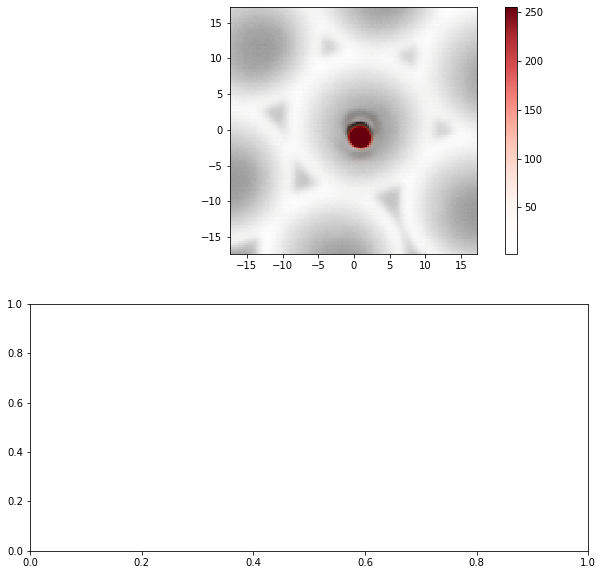

In [2]:
# Load and Plot saved dataset

sample_dir = "Sample_Solstis940_OEland_T_2024-04-07-18-49-27"
filename = "GalvoScan_polystyrene_20um_2024-04-07-18-49-27.h5"
ds = load_data_from_file(sample_dir, filename)
fig = plot_scan_data(ds, wf_cmap=cm.binary, laser_cmap=cm.Reds)

# Laser Spot analysis

In [ ]:
def plot_spotzoom_wf(wf_img, Dxy=10*u.um,figsize=(4.5,4.5),laser_cmap=cm.winter,
    x_wtext=-3,y_wtext=-3,rc_params=srs_rc_params):
    """
    Estimate spot size from widefield image and laser spot image (no galvo scan ds necessary)
    """
    x_img, y_img = img_spatial_axes(wf_img)

    #find spot zoom inds
    ix0, iy0 = [np.nanargmin(np.abs(xx)) for xx in
                [x_img, y_img]]  # Find indices of min x and min y values (at center)
    npix_half = np.round((Dxy / 2. / dx_dpix).m_as(u.dimensionless))  # Find (number of pixels)/2 making up Dxy
    ix_min, ix_max = int((ix0 - npix_half)), int(
        (ix0 + npix_half))  # Shift min and max pixel indices to boundary set by Dxy
    iy_min, iy_max = int((iy0 - npix_half)), int((iy0 + npix_half))

    laser_cmap = transparent_cmap(laser_cmap)
    # ix_min_sz, ix_max_sz, iy_min_sz, iy_max_sz = spotzoom_inds(ds, Dxy=Dxy)
    ix0 = int(np.round((ix_min + ix_max)/2.)) - ix_min  #Center around 0
    iy0 = int(np.round((iy_min + iy_max)/2.)) - iy_min  #Center around 0
    X = x_img[ix_min:ix_max]  #Cropped x axis
    Y = y_img[iy_min:iy_max]  #Cropped y axis
    Z_bg = wf_img.min()  #Intensity background
    Z = wf_img[ix_min:ix_max,iy_min:iy_max] - Z_bg  #Subtract off intensity background of cropped laser spot image
    Z_xcut = (1.0 * Z[:,iy0]) / Z.max()  #X-slice of laser_spot_image normalized to laser spot intensity
    Z_ycut = (1.0 * Z[ix0,:]) / Z.max()  #Y-slice of laser_spot_image normalized to laser spot intensity
    p_x,pcov_x = curve_fit(gaussian,X.m_as(u.um),Z_xcut,[1.0,0.0,1.0])
    p_y,pcov_y = curve_fit(gaussian,Y.m_as(u.um),Z_ycut,[1.0,0.0,1.0])
    wx,x0_fit,I0x = p_x
    wy,y0_fit,I0y = p_y
    x_fit = np.linspace(X.m_as(u.um).min(),X.m_as(u.um).max(),100)
    y_fit = np.linspace(Y.m_as(u.um).min(),Y.m_as(u.um).max(),100)
    Z_xcut_fit = gaussian(x_fit,wx,x0_fit,I0x)
    Z_ycut_fit = gaussian(y_fit,wy,y0_fit,I0y)
    fwhm = np.max([wx, wy]) * np.sqrt(2 * np.log(2))
    with mpl.rc_context(rc_params):
        fig, ax = plt.subplots(2,2,
        figsize=figsize,
        sharex="col",
        sharey="row",
        gridspec_kw={"wspace":0,"hspace":0,"width_ratios":[1,0.2],"height_ratios":[0.2,1]},
    )
        p0 = ax[1,0].pcolormesh(X,Y,np.fliplr(Z.T),cmap=laser_cmap)
        ax[1,0].set_aspect("equal")
        ly_fit = ax[1,1].plot(Z_ycut_fit,y_fit,'k--')
        lx_fit = ax[0,0].plot(x_fit,Z_xcut_fit,'k--')
        sy = ax[1,1].scatter(Z_ycut,Y)
        sx = ax[0,0].scatter(X,Z_xcut,)
        ax[1,0].set_xlabel("x (μm)")
        ax[1,0].set_ylabel("y (μm)")
        ax[1, 0].text(x_wtext, y_wtext, f"x waist: {wx:2.2f} μm" + "\n" + f"y waist: {wy:2.2f} μm")
        ax[0, 0].set_title("FWHM: %2.2f μm" % fwhm)
    return fig, ax

In [2]:
from cv2 import imread

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:323: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax.pcolormesh(y_img, x_img, img[::-1, :], cmap=wf_cmap)


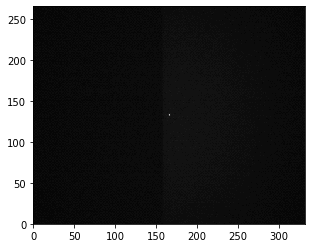

In [9]:
sample_dir = "Sample_Nikon20x_y_2024-04-11-17-40-38"
img_name = "O-Eland1040_USAF-R_1ms.tif"
img_dir = os.path.join("experiment_control",img_name)

img = imread(img_name)
img = np.sum(img, axis=-1)
fig = plot_widefield_img(img, wf_cmap='gray')

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:164: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p0 = ax[1,0].pcolormesh(X,Y,np.fliplr(Z.T),cmap=laser_cmap)
C:\Users\Prismo\miniconda3\lib\site-packages\numpy\ma\core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


(<Figure size 337.5x337.5 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'FWHM: 1.53 μm'}>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='x (μm)', ylabel='y (μm)'>, <AxesSubplot:>]],
       dtype=object))

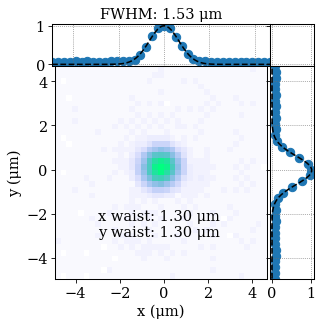

In [10]:
plot_spotzoom_wf(img)

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:108: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p0 = ax[1, 0].pcolormesh(X, Y, np.fliplr(Z.T), cmap=laser_cmap)
C:\Users\Prismo\miniconda3\lib\site-packages\numpy\ma\core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


(<Figure size 337.5x337.5 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='x (μm)', ylabel='y (μm)'>, <AxesSubplot:>]],
       dtype=object))

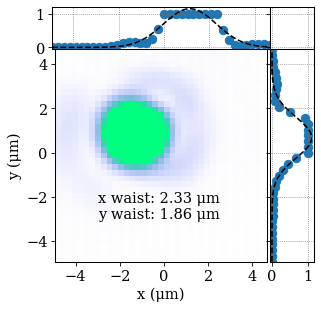

In [4]:
plot_spotzoom(ds)

loading file: knifeScan_OEland1040_2024-04-12-11-47-52.h5
importing pd_arr...
importing pos_arr...
importing attr axis...
importing attr num_avg...
importing attr scan_length...
micrometer
importing attr scan_length_units...
importing attr step_size...
micrometer
importing attr step_size_units...
σ = 0.65μm


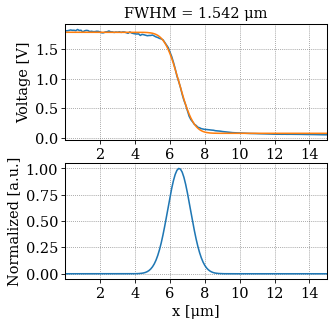

In [2]:
sample_dir = "Sample_Nikon20x_y_2024-04-11-17-40-38"
filename = "knifeScan_OEland1040_2024-04-12-11-47-52.h5"
ds_spot = load_data_from_file(sample_dir, filename)

fig = plot_knife_scan(ds_spot)

SyntaxError: unexpected character after line continuation character (2440352814.py, line 1)

# Plot spectra

loading file: Spectra_SolstisSweep_OEland_T_30ms_2024-04-12-18-28-22.h5
importing raman_shift...
importing spec...
importing tap_power...
importing wavelengths...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr num_avg...
importing attr wav_settle_time...
second
importing attr wav_settle_time_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
importing attr Δwav...
nanometer
importing attr Δwav_units...


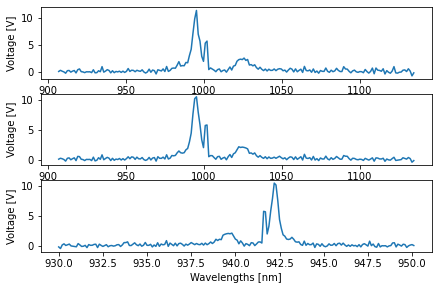

In [6]:
sample_dir = "Sample_polystyrene_bulk_2024-04-12-16-50-21"
filename = "Spectra_SolstisSweep_OEland_T_30ms_2024-04-12-18-28-22.h5"
ds_spec = load_data_from_file(sample_dir, filename)

fig=plot_spectra(ds_spec)

loading file: Spectra_SolstisSweep_OEland_T_2024-04-12-16-50-46.h5
importing raman_shift...
importing spec...
importing tap_power...
importing wavelengths...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr num_avg...
importing attr wav_settle_time...
second
importing attr wav_settle_time_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
importing attr Δwav...
nanometer
importing attr Δwav_units...


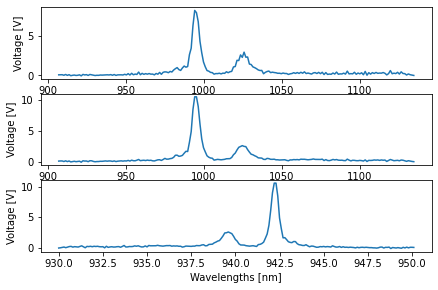

In [5]:
sample_dir = "Sample_polystyrene_bulk_2024-04-12-16-50-21"
filename = "Spectra_SolstisSweep_OEland_T_2024-04-12-16-50-46.h5"
ds_spec = load_data_from_file(sample_dir, filename)
fig = plot_spectra(ds_spec)

KeyError: 'spec'

In [ ]:
# Functions for plotting data before 4/9/24

def save_scan_images(ds,fname,fpath=False,wf_cmap=cm.binary_r,laser_cmap=cm.winter,srs_cmap=cm.inferno,rc_params=srs_rc_params,format='png',**kwargs):
    """
    Save data and figs for following images:
    (1) Widefield image
    (2) Laser spot superimposed on widefield image
    (3) Widefield image zoomed 
    (4) Laser spot superimposed on cropped widefield image
    (5) SRS image
    """
    i_xmax, i_xmin, i_ymax, i_ymin = wf_img_inds(ds)
    
    x_off = 10
    y_off = 40
    i_xmax += x_off
    i_xmin += x_off
    i_ymin += y_off
    i_ymax += y_off
    
    laser_cmap = transparent_cmap(laser_cmap)
    img_data = [
#         (ds["y_img"].m, ds["x_img"].m, (np.flipud(ds["wf_img"]), ), (wf_cmap,),"wf_"+fname+"."+format),
        (ds["y_img"].m, ds["x_img"].m, (np.flipud(ds["wf_img"]), np.flipud(ds["laser_spot_img"])),(wf_cmap,laser_cmap),"wfls_"+fname+"."+format),
#         (ds["y_img"][i_ymin:i_ymax].m, ds["x_img"][i_xmin:i_xmax].m, (np.flipud(ds["wf_img"][i_xmin:i_xmax,i_ymin:i_ymax]), ), (wf_cmap,), "wfzoom_"+fname+"."+format),
        (ds["y_img"][i_ymin:i_ymax].m, ds["x_img"][i_xmin:i_xmax].m, (np.flipud(ds["wf_img"][i_xmin:i_xmax,i_ymin:i_ymax]), np.flipud(ds["laser_spot_img"][i_xmin:i_xmax,i_ymin:i_ymax])), (wf_cmap,laser_cmap), "wflszoom_"+fname+"."+format),
        (ds["y"].m, ds["x"].m, (np.flipud(np.transpose(ds["Vsig_g"].m)), ), (srs_cmap,), "srs_"+fname+"."+format),
    ]
    for X,Y,Z,cmap,fname in img_data:
         save_single_img(X,Y,Z,cmap,fname,fpath=fpath,xlabel="x (μm)",ylabel="y (μm)",cbar=False,cbar_label=None,rc_params=rc_params,format=format,**kwargs)
    return


def save_single_img(X,Y,Z,cmap,fname,fpath=False,xlabel="x (μm)",ylabel="y (μm)",cbar=False,cbar_label=None,figsize=(4,6),format='png',rc_params=srs_rc_params,**kwargs):
    """
    Given X,Y,Z arrays, plot and save figure
    """
    with mpl.rc_context(rc_params):
        fig,ax = plt.subplots(1,1) #,figsize=figsize) #**kwargs)
        ps = [ax.pcolormesh(X,Y,zz,cmap=ccmm,vmin=np.nanmin(zz),vmax=np.nanmax(zz)) for (zz,ccmm) in zip(Z,cmap) ]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if cbar:
            cb = plt.colorbar(ps[-1],ax=ax,label=cbar_label)
        ax.set_aspect("equal")
        # fig.tight_layout()
        if fpath:
            fname=os.path.normpath(os.path.join(fpath,fname))
        plt.savefig(fname, dpi=None, facecolor=None, edgecolor=None,
            orientation='portrait', papertype=None, format=format,
            transparent=True, bbox_inches=None, pad_inches=0.5)
    return fig

def plot_scan_data(ds,wf_cmap=cm.binary,laser_cmap=cm.Reds, srs_cmap=cm.inferno):
    """
    Plot 2x1 subplots with [0] laser spot superimposed on cropped widefield image, and [1] SRS image
    :param ds: from collect_scan()
    :return: fig with (2) subplots
    """
    laser_cmap = transparent_cmap(laser_cmap)
    fig, ax = plt.subplots(2,1, figsize = (10,10))
    
    # Find wf image indices corresponding to scan area, add manual offset to match scan area
    i_xmax, i_xmin, i_ymax, i_ymin = wf_img_inds(ds)
    x_off = 10
    y_off = 40
    i_xmax += x_off
    i_xmin += x_off
    i_ymin += y_off
    i_ymax += y_off
 
    # [0] Laser spot + cropped widefield image
    im0 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                              ds["wf_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=wf_cmap)
    im1 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                              ds["laser_spot_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=laser_cmap)
    cb0 = plt.colorbar(im1, ax=ax[0])
    ax[0].set_aspect("equal")

    # [1] SRS (galvo) image
    p0 = ax[1].pcolormesh(ds["y"].m, ds["x"].m, np.flipud(np.transpose(ds["Vsig_g"].m)), cmap=srs_cmap)
    cb1 = plt.colorbar(p0, ax=ax[1])
    ax[1].set_aspect("equal")

    plt.show()
    return fig